In [1]:
%load_ext autoreload
%autoreload 2

In [132]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../modules')
from FSC import FSC_DiscreteObs
import ObsModels 

# $M = 2$, $A = 2$, $Y = 2$

In [109]:
NStepsObs = 1000
Y = 2
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 50*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NStepsObs, RateMatrixObs)

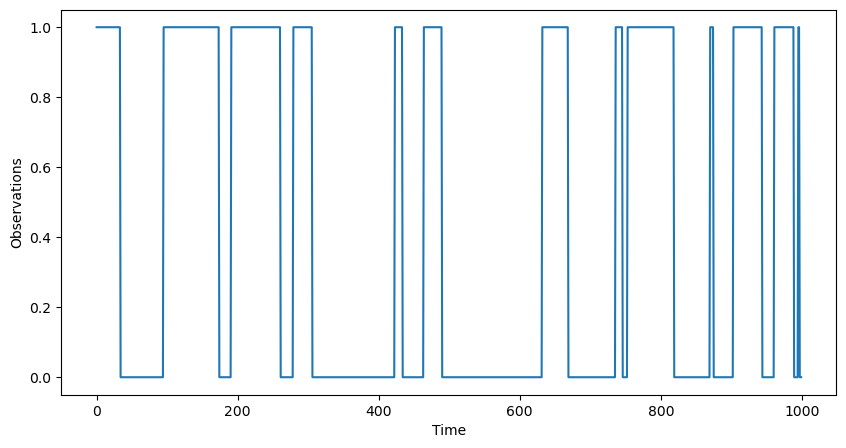

In [110]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations, markersize=2)
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [111]:
M = 2
A = 2
#Theta = np.random.randn(Y, M, M, A)

ThetaFollowSwitch = np.array([[[[10, 0.01], [0.01, 0.01]],
                               [[0.01, 0.01], [0.01, 10]]],
                              [[[0.01, 0.01], [0.01, 10]],
                               [[10, 0.01], [0.01, 0.01]]]])


Psi = np.array([1, 2])

FSC = FSC_DiscreteObs(ThetaFollowSwitch, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 2 observations.


In [112]:
FSC.load_observations(observations)

In [113]:
NSteps = 200
trajectory = FSC.generate_trajectory(NSteps)
Time = np.arange(NSteps)

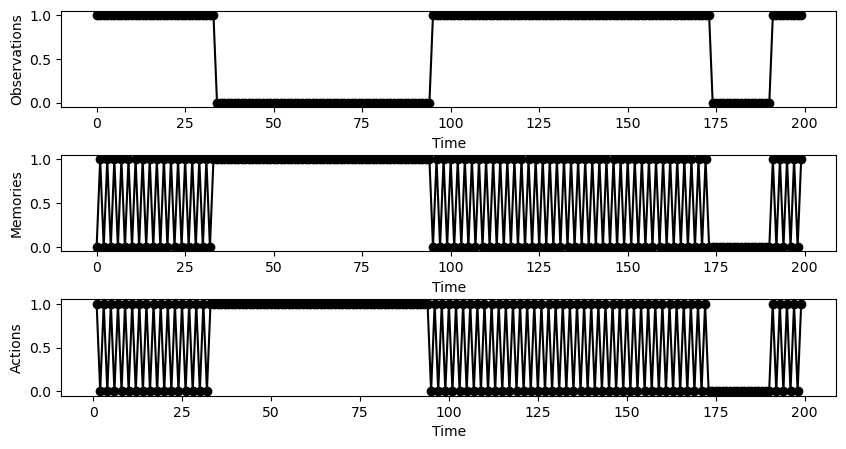

In [117]:
fig, ax = plt.subplots(3,1, figsize=(10,5))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(Time, trajectory["observations"], 'o', c= 'k')
ax[0].plot(Time, trajectory["observations"], c = 'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Observations')

ax[1].plot(Time, trajectory["memories"], 'o', c= 'k')
ax[1].plot(Time, trajectory["memories"], c = 'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Memories')

ax[2].plot(Time[1:], trajectory["actions"][1:], 'o', c= 'k')
ax[2].plot(Time[1:], trajectory["actions"][1:], c = 'k')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Actions')

plt.show()

# $M = 2$, $A = 2$, $Y = 3$

In [121]:
NStepsObs = 1000
Y = 3
RateMatrixObs = np.ones((Y,Y))
RateMatrixObs = RateMatrixObs + 50*np.eye(Y)

observations = ObsModels.DiscreteMarkovChain(NStepsObs, RateMatrixObs)

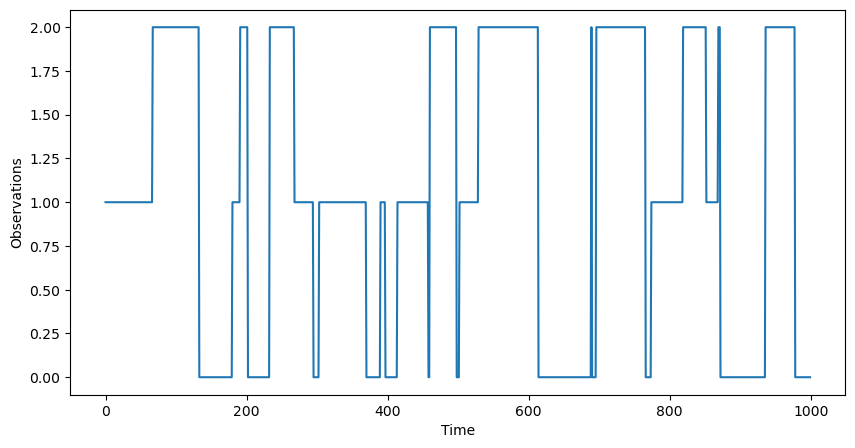

In [122]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(observations, markersize=2)
ax.set_xlabel('Time')
ax.set_ylabel('Observations')

plt.show()

In [215]:
M = 2
A = 2
#Theta = np.random.randn(Y, M, M, A)

ThetaFollowSwitchFollow = np.zeros((Y, M, M, A))

# when receiving a zero observation, the memory is reset to zero and action 0 is taken
ThetaFollowSwitchFollow[0] = np.array([[[10, 0.01], [0.01, 0.01]],
                                      [[10, 0.01], [0.01, 0.01]]])

# when receiving a two observation, the memory is reset to one and action 1 is taken
ThetaFollowSwitchFollow[2] = np.array([[[0.01, 0.01], [0.01, 10]],
                                      [[0.01,0.01], [0.01, 10]]])

# when receiving a one observation, the memory keeps switching between 0 and 1 and the actions is random
ThetaFollowSwitchFollow[1] = np.array([[[0.01, 0.01], [10, 10]],
                                      [[10, 10], [0.01, 0.01]]])

Psi = np.array([1, 1])

FSC = FSC_DiscreteObs(ThetaFollowSwitchFollow, Psi, verbose = True)

Initializing FSC with 2 memory states, 2 actions, and 3 observations.


In [217]:
FSC.load_observations(observations)

In [218]:
NSteps = 200
trajectory = FSC.generate_trajectory(NSteps)
Time = np.arange(NSteps)

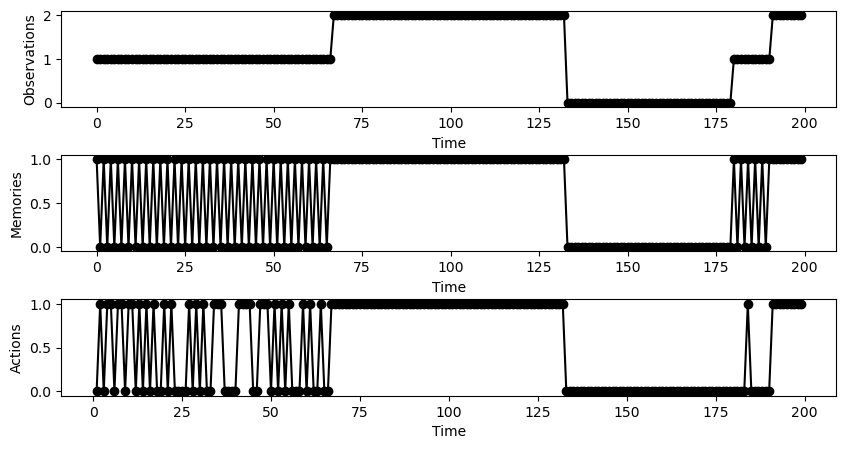

In [219]:
fig, ax = plt.subplots(3,1, figsize=(10,5))
plt.subplots_adjust(hspace=0.5)

ax[0].plot(Time, trajectory["observations"], 'o', c= 'k')
ax[0].plot(Time, trajectory["observations"], c = 'k')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Observations')

ax[1].plot(Time, trajectory["memories"], 'o', c= 'k')
ax[1].plot(Time, trajectory["memories"], c = 'k')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Memories')

ax[2].plot(Time[1:], trajectory["actions"][1:], 'o', c= 'k')
ax[2].plot(Time[1:], trajectory["actions"][1:], c = 'k')
ax[2].set_xlabel('Time')
ax[2].set_ylabel('Actions')

plt.show()